# Exploring Las Vegas

## Introduction

Whenever a person wants to visit any city or place that is new to them they eventually look for the places to eat in addition to the hangout places. For finding hangout places there are various other options. Finding better restaurants and café is problem when there are many options and the city is very dense. Thus to find any eating place we check their ratings and reviews which are give us pretty much fair opinion about the restaurant. Now how about we getting an idea about the price range? This is what we are going to explore and analyze here. Also, we will also be combining the information about the location of the venues in the city .

Las Vegas is  is the 28th most populated city in the united states and the most populated city in the state of Naveda. Las vegas is internationally renowned major resort city, known primarily for shopping, fine dine, entertainment and nightlife. Las vegas also serves as the leading financial, commercial and culture center for Naveda. This project explores various venues in Vegas and attributes the data based on user ratings and price range or average price.

To explore the information stated we have made use of two location API that is Foursquare API and the Zomato API. Using Foursquare API we were able to set the boundaries ( using radius parameter) and Using Zomato API we were able to fetch the information about various venues like name, address, rating, price range and category. Using the data from the foursquare and Zomato API maps have also been plotted using Folium to make more clear visualization.

## Data Collection from APIs

We will be taking the map of Las Vegas from the Folium Liberary


I have used two API for fetching the data.
#### Foursquare API
we have used this API for getting the following details about the venues from the center  of the city upto 6 Km in all directions
1. Name: Name of the Venue
2. Category : Type of the venue(eg. cafe, restaurant etc.)
3. Latitude : Latitude Value of the venue
4. Longitude : The longitude value of the venue

#### Zomato API
we will be using this API for retrieving the following information.
1. Name : The name of the venue
2. Address: The complete address of the venue.
3. Price Range : The price range of the venue as defined be the Zomato.
4. Rating : The ratings as provided by many Users.
5. Latitude : The Latitude value of the venue.
6. Longitude : Longitude value of the venue.

#### Importing Liberaries
 we will be importing some basic liberaries that we know that we will be needing for the project.Othe liberaries we will be importing when we will be needing them.

In [1]:
import requests 
import pandas as pd 
import numpy as np 
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Lets supply directly the values of latitude and longitude of LV to generate map on folium

In [2]:
lv_latitude= 36.114647
lv_longitude= -115.172813
print('The geographical cordinates of Las Vegas are {},{}.'.format(lv_latitude,lv_longitude))

The geographical cordinates of Las Vegas are 36.114647,-115.172813.


Lets Use the Folium Liberary to generate the map centered at the latitude and longitude values provided

In [3]:
Vegas_map=folium.Map(location=[lv_latitude,lv_longitude], zoom_start=13)
folium.Marker([lv_latitude,lv_longitude]).add_to(Vegas_map)
Vegas_map

In [30]:
 # @hidden cell
foresquare_client_id='KJA4OIL1LHTYEQZP1ZC0DMGWJNRLZ0E10AP52CRQQ2GLQHAZ'
foresquare_client_key='D1U2UGDG1MNQT4PLXSIFTY0OWMLV0NDVV3EHINI1S4ZPAGQD'
radius=5000
no_of_venues=100
version='20200717'

## Foursquare API
we started by fetching all the nearby venues to the city center upto 3 km using the foursquare API. It has the explore API which allow us to find the venue recommendations within a given radius from the given coordinates. we will use this API to find all the venues needed.

we also define the get_category_method to get the correct category of each venue.

In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list=row['categories']
    except:
        categories_list=row['venue.categories']
        if len(categories_list)==0:
            return None
        else:
            return categories_list[0]['name']

We willl call the API over and over till we get all the venues within the given distance.The Maximum venues this APi can fetch is 100, so we will fetch all the venues by iteratively calling this API and increasing the offset each time. 
* Foursquare API requires client_id and client_secret_key to function which can be accessed after creating a developer account.
* We will set the radius as 4 Kilometers.

In [6]:
pd.set_option('display.max_rows',None)

total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])
offset=0
while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(foresquare_client_id, 
                                                                        foresquare_client_key, 
                                                                        version, 
                                                                        lv_latitude, 
                                                                        lv_longitude, 
                                                                        radius,
                                                                        no_of_venues,
                                                                        offset
                                                                        )
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, radius/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched <= 250):
        break
    else:
        offset = offset + 10
    
foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 5.0 Km

Total 100 venues fetched


## Zomato API
The zomato API allows using its search APi to search for any given venue based on certain search filter such as name, latitude, longitude and more.

The Zomato also requires a Zomato User key which can be accessed with a developer acoount.

Here we will use attributes of various venues fetched from the ___Foursquare API__ to Use the search API and get more information regarding each venue. We have specifically used _name_ , _latitude_ and _longitude_.


In [31]:
# @HIDDEN CELL
headers={'user-key':'d3af32be2be498596789d8abdfccd0df'}


In [8]:
venues_info=[]
for index, row in foursquare_venues.iterrows():
    print('Fetching Data for Venue: {}'.format(index+1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_info.append(venue)
    else:
        #break
        continue
        #venues_info.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_info,columns = ['venue','latitude','longitude','price_range','rating','address'])
zomato_venues

Fetching Data for Venue: 1
Fetching Data for Venue: 2
Fetching Data for Venue: 3
Fetching Data for Venue: 4
Fetching Data for Venue: 5
Fetching Data for Venue: 6
Fetching Data for Venue: 7
Fetching Data for Venue: 8
Fetching Data for Venue: 9
Fetching Data for Venue: 10
Fetching Data for Venue: 11
Fetching Data for Venue: 12
Fetching Data for Venue: 13
Fetching Data for Venue: 14
Fetching Data for Venue: 15
Fetching Data for Venue: 16
Fetching Data for Venue: 17
Fetching Data for Venue: 18
Fetching Data for Venue: 19
Fetching Data for Venue: 20
Fetching Data for Venue: 21
Fetching Data for Venue: 22
Fetching Data for Venue: 23
Fetching Data for Venue: 24
Fetching Data for Venue: 25
Fetching Data for Venue: 26
Fetching Data for Venue: 27
Fetching Data for Venue: 28
Fetching Data for Venue: 29
Fetching Data for Venue: 30
Fetching Data for Venue: 31
Fetching Data for Venue: 32
Fetching Data for Venue: 33
Fetching Data for Venue: 34
Fetching Data for Venue: 35
Fetching Data for Venue: 36
F

,venue,latitude,longitude,price_range,rating,address
0,Cafè Bellagio - Bellagio,36.1117120000,-115.1753400000,3,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ..."
1,Bacchanal Buffet - Caesars Palace,36.1161110000,-115.1744000000,4,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South..."
2,Mon Ami Gabi,36.1121300000,-115.1694200000,4,4.6,3655 Las Vegas Boulevard South 89109
3,Bacchanal Buffet - Caesars Palace,36.1161110000,-115.1744000000,4,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South..."
4,Cafè Bellagio - Bellagio,36.1117120000,-115.1753400000,3,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ..."
5,Cafè Bellagio - Bellagio,36.1117120000,-115.1753400000,3,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ..."
6,Nobu Restaurant,36.1168508000,-115.1753095000,4,0,3570 South Las Vegas Boulevard
7,Gordon Ramsay Steak,36.1127578000,-115.1712046000,4,4.6,3655 South Las Vegas Boulevard 89109
8,Club Cappuccino,36.1156750000,-115.1725564000,1,0,"3555 S Las Vegas Blvd, Las Vegas 89109"
9,Carmine's Italian Restaurant - Las Vegas,36.1190500000,-115.1762300000,3,3.6,"Forum Shops At Caesars, 3500 South Las Vegas B..."


## Data Cleaning
The Data from multiple resources might not always align. Thus it is important to combine the retrieved data from multiple resources properly.

We will be plotting the data fetched from both of the APIs.  we will then combine data points that have their latitudes and longitude values veri close to one another. Next from the remaining venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

First we will be plotting map for the data fetched from the Foursquare.

In [9]:
Vegas_map = folium.Map(location = [lv_latitude, lv_longitude], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(Vegas_map)  

Vegas_map.save("Venues by Foursquare.html")
Vegas_map

Here we can see that clusters around the areas like __Miracle Mile Shops ,Jockey Club , Caesers Palace , Flamingo Keskusta__ and __The Crystal TramStation__.

Now we will plot the Zomato data on the Map

In [28]:
zomato_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 6 columns):
venue          93 non-null object
latitude       93 non-null float64
longitude      93 non-null float64
price_range    93 non-null int64
rating         93 non-null object
address        93 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 4.4+ KB


In [29]:
Vegas_map = folium.Map(location = [lv_latitude, lv_longitude], zoom_start = 13)

for venue, address, latitude, longitude in zip (zomato_venues['venue'],zomato_venues['address'],zomato_venues['latitude'],zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius =5 ,
        popup = label,
        color = 'red',
        fill = True ,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(Vegas_map)

    
Vegas_map.save(" Venues by Zomato.html ")
Vegas_map

From the graph we can infer that there are some places that both the data( Foursqaure and Zomato) points them at same place but there also some places that are different.

we will have to check the laitude and longitude values of each corresponding venue match to combine the two datasets. 
For doing that we will be rounding both the latitude and longitude values upto 4 decimal places, Then calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should idealy mean that the two locations are same.

In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat),4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng),4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.004) & (abs(dataset['lng_diff']) <= 0.004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_range,rating,address,lat_diff,lng_diff
0,Fountains of Bellagio,Fountain,36.1125,-115.1732,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",-0.0008,-0.0021
1,Caesars Palace Hotel & Casino,Casino,36.1163,-115.1748,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South...",-0.0002,0.0004
2,Mon Ami Gabi,French Restaurant,36.1127,-115.1729,Mon Ami Gabi,36.1121,-115.1694,4.0,4.6,3655 Las Vegas Boulevard South 89109,-0.0006,0.0035
3,Caesars Palace Gardens,Hotel,36.1159,-115.1738,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South...",0.0002,-0.0006
4,Bellagio Hotel & Casino,Hotel,36.1125,-115.1761,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",-0.0008,0.0008
5,Qua Baths & Spa,Spa,36.1152,-115.1756,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",-0.0035,0.0003
6,Absinthe,Theater,36.1155,-115.1739,Nobu Restaurant,36.1169,-115.1753,4.0,0,3570 South Las Vegas Boulevard,0.0014,-0.0014
7,Nobu Restaurant Caesars Palace,Japanese Restaurant,36.1169,-115.1753,Club Cappuccino,36.1157,-115.1726,1.0,0,"3555 S Las Vegas Blvd, Las Vegas 89109",-0.0012,0.0027
8,The Colosseum at Caesars Palace,Concert Hall,36.1181,-115.1743,Good2go,36.1185,-115.1730,1.0,0,"3476 Las Vegas Blvd S, Las Vegas 89109",0.0004,0.0013
9,CHANEL Boutique,Boutique,36.1141,-115.1746,Mesa Grill,36.1171,-115.1748,4.0,4.3,3570 South Las Vegas Boulevard 89109,0.0030,-0.0002


By just taking a short analysis of the names of the venues from both APIs, we can see that some names are complete mismatch.

thus we will be selecting the venue name from the Zomato API and removing all other unnecessary columns.

In [14]:
selected_venues=selected_venues.drop(columns=['name','lat','lng','lat_diff','lng_diff'])

we will also drop the rows having rating equals to zero.

In [15]:
selected_venues=selected_venues[selected_venues['rating']!=0.0]


now let us have a look at the data we are left with and no. of rows.

In [16]:
print("Total venues available : {}".format(selected_venues.shape[0]))
selected_venues.head(5)

Total venues available : 29


,categories,venue,latitude,longitude,price_range,rating,address
0,Fountain,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ..."
1,Casino,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South..."
2,French Restaurant,Mon Ami Gabi,36.1121,-115.1694,4.0,4.6,3655 Las Vegas Boulevard South 89109
3,Hotel,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South..."
4,Hotel,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ..."


# Methodology
This project aims at identifying the venues in Las Vegas based on their rating. Using this visitors can identify the venues the want to visit on the basis of the rating.

__Step 1.__ We firstly retrieved data from the two APIS, namely Foursquare and Zomato. We extracted the venues information like latitude longitude and name of the venue from the Foursquare API and using the information from foursquare about venues we iteratively retrieved the additional information about the venues like rating price range etc.

__Step 2.__ Next we explored the data retrieved from the two APIs on the map and identified the various places where we found the cluster of venues.Also data from both the sources is combined carefully based on the latitude and longitude values. The final data setwould include the rating for each venue.

__Step 3.__ We then analyse the data based on the ratings. We will identify the places where many venues are located so that any visitor can go one place and enjoy the option to choose amongest venue options. We will also be exploring the places with high rating and low rating along with the map showing the high and low rated places.

__Step 4.__ Lastly we will be clustering the venues based on the available information of each venue. This wil help us in recommendation.

# Analysis

The complete dataset is now in its final form.

we will inspect these veues based on their rating. The rating of a venue are based on User reviews and belongs to a range from 1-5.

### Categories
We have verious types of venues in the final dataset. we will take a look at the venues and check which are the majority venue categories in the list.

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


<BarContainer object of 25 artists>

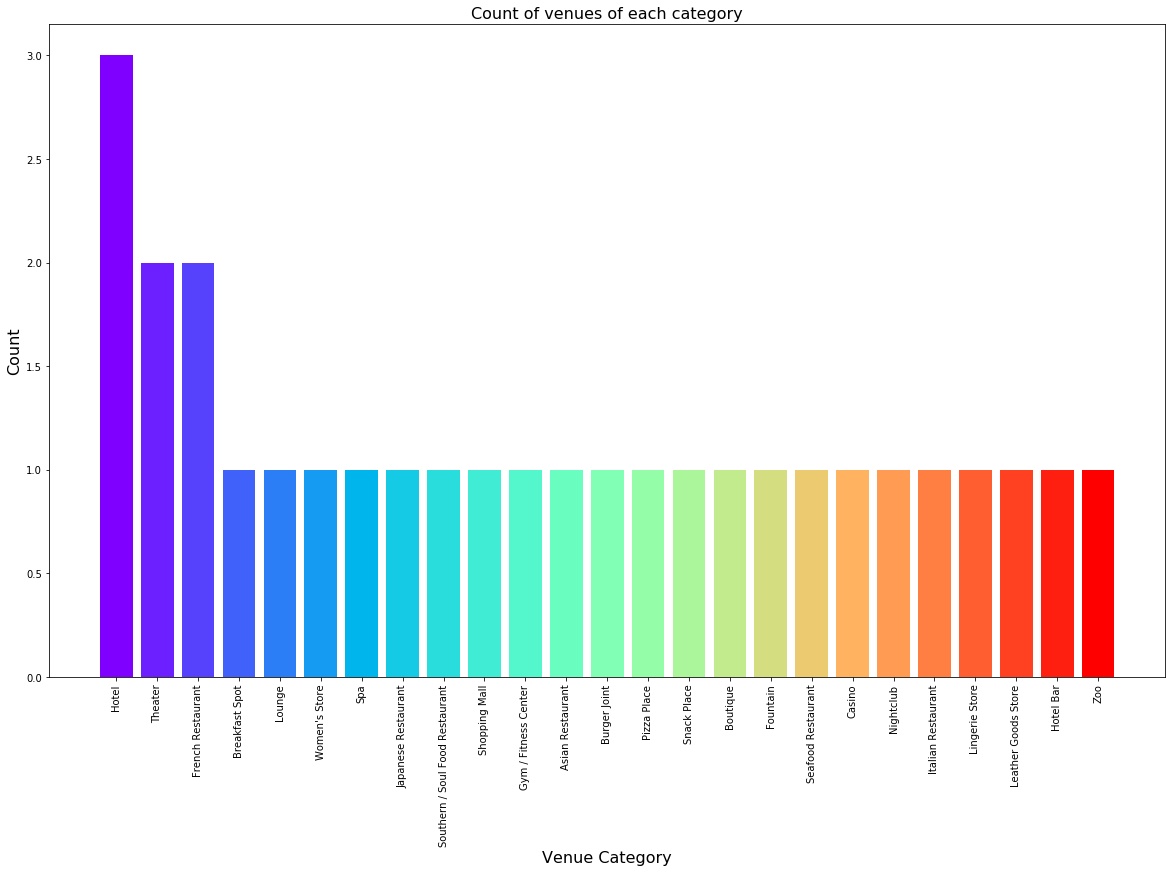

In [18]:
venue_dist= selected_venues['categories'].value_counts()
colors= cm.rainbow(np.linspace(0,1,len(venue_dist.index)))
plt.figure(figsize=(20,12))
plt.xticks(rotation=90)
plt.xlabel("Venue Category",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.title("Count of venues of each category",fontsize=16)
plt.bar(venue_dist.index,venue_dist.values,color=colors)


From the above graph we can infer that majorly there are __Hostels__ next we have __Theatre__ and the we have 3 places in equal amount that are __Japanese Restaurant, Lounge__ and __French Restaurants__.


### Rating
Rating of a venue is an important factor which helps visitor decide whether  it is worthit to visit place. 

For plotting the rating of various venues we first identify the various rating values and the do plotting with their counts to see the most common rating.

For plotting we will be using the Bar Plot.

Text(0.5, 1.0, 'Count of venues with given rating')

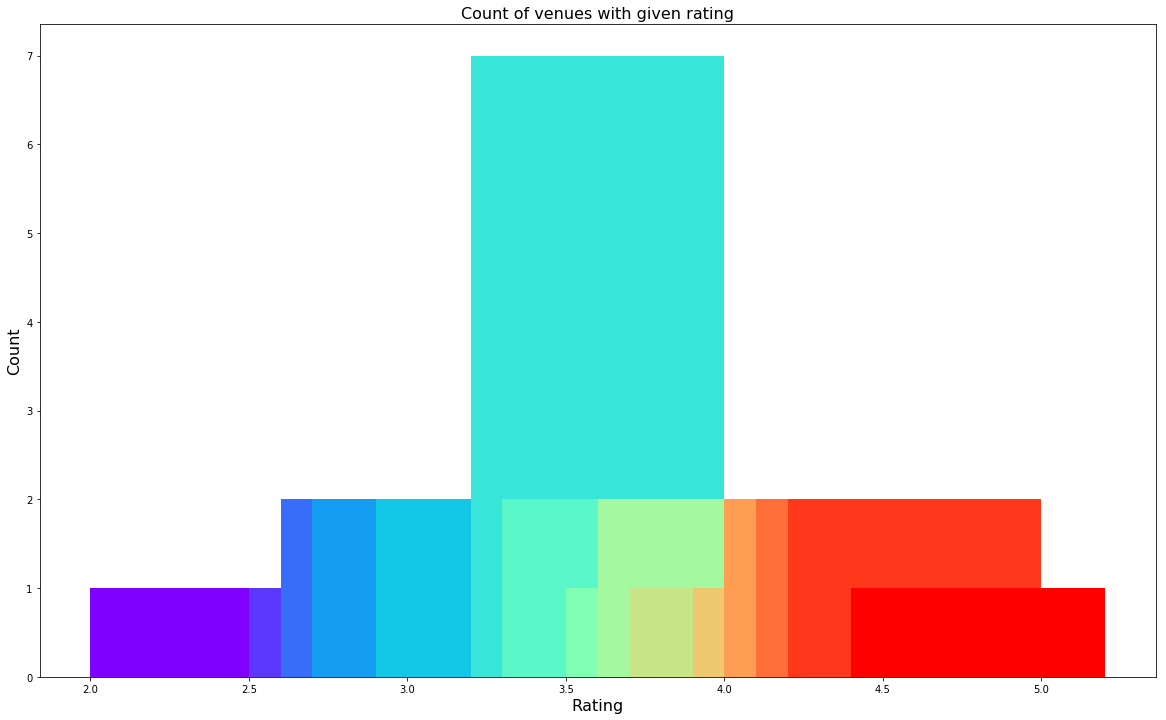

In [19]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

Infering from the plot we can see that majority of venues have rating between 3.5 and 4.

#### Binning
Lets create bins for various rating and plot them in different colors on the map. Ratings will be divided between 4 bins: 
* 1-2
* 2-3
* 3-4
* 4-5


In [20]:
bins=[1.0,2.0,3.0,4.0,5.0]
labels=['Low','Average','Good','Very Good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [21]:
color_map = {'Low': 'red', 'Average': 'orange', 'Good': 'green', 'Very Good': 'darkgreen'}

Vegas_map = folium.Map(location = [lv_latitude, lv_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(Vegas_map)  

Vegas_map.save("Venues Ratings.html")
Vegas_map

In the map it appears clearly that  Most of the places in famous places like __Jockey Club, Ceasar Palace__ and __Miracle Mile Shops__ have good or very good reviews.

### Clustering 
we will now cluster all these venues based on their price range, location and more to identify similar venues and the relatipnship amongest them. We'll cluster the venues into two separate groups.


In [22]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels4', kMeans.labels_)


selected_venues.head(5)

,cluster_labels4,categories,venue,latitude,longitude,price_range,rating,address,rating_bin
0,0,Fountain,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",Good
1,0,Casino,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South...",Very Good
2,0,French Restaurant,Mon Ami Gabi,36.1121,-115.1694,4.0,4.6,3655 Las Vegas Boulevard South 89109,Very Good
3,0,Hotel,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South...",Very Good
4,0,Hotel,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",Good


In [23]:
Vegas_map = folium.Map(location = [lv_latitude, lv_longitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels4'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(Vegas_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(Vegas_map)

Vegas_map.save("Venues Clusters.html")
Vegas_map

From Above we can see that there is one cluster that is spread over the city and another one is over only limited places specifically in city center

Lets check the venues of the two clusters


In [24]:
result = selected_venues[selected_venues['cluster_labels4'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels4,categories,venue,latitude,longitude,price_range,rating,address,rating_bin
0,0,Fountain,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",Good
1,0,Casino,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South...",Very Good
2,0,French Restaurant,Mon Ami Gabi,36.1121,-115.1694,4.0,4.6,3655 Las Vegas Boulevard South 89109,Very Good
3,0,Hotel,Bacchanal Buffet - Caesars Palace,36.1161,-115.1744,4.0,4.5,"Caesars Palace, 3570 Las Vegas Boulevard South...",Very Good
4,0,Hotel,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",Good
5,0,Spa,Cafè Bellagio - Bellagio,36.1117,-115.1753,3.0,3.6,"Bellagio, 3600 South Las Vegas Boulevard, The ...",Good
6,0,Boutique,Mesa Grill,36.1171,-115.1748,4.0,4.3,3570 South Las Vegas Boulevard 89109,Very Good
7,0,Lingerie Store,Battista's Hole in the Wall,36.1150,-115.1681,3.0,4.0,"4041 Linq Lane, The Strip, Las Vegas 89109",Good
8,0,Pizza Place,BLT Steak,36.1139,-115.1701,4.0,3.6,Bally'South Las Vegas Hotel & Casino 3645 Las ...,Good
9,0,Snack Place,Outback Steakhouse,36.1177,-115.1669,3.0,3.3,3411 Las Vegas Boulevard South 89109,Good


In [25]:


print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))



These venues for cluster 0 have mean price range of 3.64 and rating spread around 3.91


In [26]:
result = selected_venues[selected_venues['cluster_labels4'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels4,categories,venue,latitude,longitude,price_range,rating,address,rating_bin
0,1,Nightclub,Johnny Rockets,36.1141,-115.1708,1.0,3.1,"3645 S Las Vegas Blvd, Las Vegas 89109",Good
1,1,Zoo,In-N-Out Burger,36.1175,-115.1699,1.0,2.9,"3545 S. Las Vegas Boulevard, Suite L24, Las Ve...",Average
2,1,Leather Goods Store,Earl of Sandwich,36.1094,-115.1719,1.0,4.8,3667 Las Vegas Boulevard South 89109,Very Good
3,1,Burger Joint,Eggslut,36.1100,-115.1743,1.0,3.6,"3708 Las Vegas Boulevard South Level 2, The Bo...",Good
4,1,Shopping Mall,Le Cafe Ile St. Louis,36.1125,-115.1710,2.0,2.4,3655 South Las Vegas Boulevard 89109,Average
5,1,Seafood Restaurant,Vesper Bar,36.1098,-115.1758,1.0,3.0,"3708 Las Vegas Boulevard South Level 1, The Ch...",Average
6,1,Women's Store,D.O.C.G. Enoteca By Scott Conant,36.1092,-115.1732,1.0,3.0,"3708 Las Vegas Blvd South, Las Vegas 89109",Average


In [27]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.14 and rating spread around 3.26


 ## Results And Discussions
 Based on the analysis done above we came to the fllowing results:
 * On retrieving information from Foursquare and Zomato API we get the 100 venues in about radius of 3km.After cleaning the data we get only 32 venues
 * We infer that from all the venues majority of them were __Hotels__ followed by __Theaters__.
 * While the complete range of ratings range from 1 to 5, the majority venues have rating between 3.5 and 4.0, which means they provide good quality of service.
 * Finally Through Clusters we identified that there are many venues which were relatively low priced but have an average rating of 3.50. On the other hand, there are few venues which are high priced and have average rating of 3.99.

# Conclusion
The very purpose of this project was to explose the visiting places in the city of Las Vegas or simply Vegas. The information about the venues have been fetched using two APIs namely Foursquare and ZOmato. Using that information we were able to plot the map and get more clear view of the places that where they are located.The maps reveals that __Jockey Club, Ceaser Palace and Miracle Mile Shops__ are the major areas where people visit.

# Thank You